In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv("local_data/temp_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'local_data/temp_data.csv'

In [ ]:
numerical_data = data.filter(data.select_dtypes(["float64", "int64"]).columns)
numerical_data = numerical_data.fillna(numerical_data.median()).dropna(axis=1)
drop_cols = [
    "id",
    "host_id",
    "name",
    "neighbourhood_group",
    "neighbourhood",
    "last_review",
    "scrape_id",
    "price_per_person",
]
numerical_data = numerical_data.drop(columns=drop_cols, errors="ignore")
numerical_data = numerical_data[
    numerical_data["price"] < numerical_data["price"].quantile(0.99)
]

In [ ]:
def transform_features(df: pd.DataFrame) -> pd.DataFrame:
    transformed_df = df.copy()

    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    if "price" in numeric_cols:
        numeric_cols.remove("price")

    sqrt_df = df[numeric_cols].apply(lambda x: np.sqrt(x - x.min() + 1))
    sqrt_df.columns = [f"sqrt_{col}" for col in numeric_cols]

    log_df = df[numeric_cols].apply(lambda x: np.log(x - x.min() + 1))
    log_df.columns = [f"log_{col}" for col in numeric_cols]

    # winsorisation
    wins_df = df[numeric_cols].apply(
        lambda x: stats.mstats.winsorize(x, limits=[0.023, 0.023])
    )
    wins_df.columns = [f"wins_{col}" for col in numeric_cols]

    return pd.concat([transformed_df, sqrt_df, log_df, wins_df], axis=1)


numerical_data_transformed = transform_features(numerical_data)

In [ ]:
X = numerical_data_transformed.drop("price", axis=1)
y = numerical_data["price"]

In [ ]:
numerical_data_transformed.sort_values("price", ascending=False).head(20)

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,...,wins_tourism_sportsactivitylocation,wins_tourism_store,wins_tourism_touristattraction,wins_tourism_winery,wins_tourism_zoo,wins_tourism_total,wins_tourism_points_within_radius,wins_noise_day,wins_noise_night,wins_noise_points_within_radius
536,36,42,47.377840,8.537840,6,2.0,3.0,927.0,1,1125,...,0.223732,0.160948,0.592814,0.0,0.000006,6.892222,405,725.357160,659.225923,10000
2345,1,1,47.377822,8.527611,2,1.0,1.0,900.0,1,365,...,0.004727,0.035804,0.009109,0.0,0.000001,8.079983,374,4816.089253,3963.299197,10000
943,6,6,47.373620,8.545650,2,1.0,1.0,888.0,1,1,...,0.015161,0.424103,0.566125,0.0,0.000009,16.454968,371,5350.190054,4509.393892,10000
946,6,6,47.375520,8.545820,2,1.0,2.0,880.0,1,1125,...,0.020410,0.111205,0.960001,0.0,0.000003,13.834025,371,3938.245973,3290.742015,10000
1648,5,9,47.335590,8.541050,16,2.0,18.0,828.0,1,365,...,0.002082,0.000000,0.000000,0.0,0.000000,1.706702,11,491.691622,424.956219,10000
239,36,42,47.369450,8.545030,8,3.0,3.0,806.0,1,1125,...,0.052120,0.093259,1.219419,0.0,0.000115,16.226136,366,4654.882053,3909.221800,10000
538,36,42,47.377270,8.539730,4,1.0,2.0,802.0,1,1125,...,0.237665,0.199553,1.219419,0.0,0.000007,11.626347,407,1501.641331,1374.237523,10000
535,36,42,47.376820,8.538830,6,2.0,3.0,802.0,1,1125,...,0.237665,0.125376,1.219419,0.0,0.000011,11.679984,407,6893.051827,5884.502217,10000
537,36,42,47.377610,8.538230,4,1.0,2.0,802.0,1,1125,...,0.237665,0.150330,0.762198,0.0,0.000006,7.787946,406,3677.757498,3342.176451,10000
1005,1,3,47.381910,8.529990,1,1.0,1.0,800.0,2,3,...,0.014016,0.124122,0.019390,0.0,0.000000,5.817061,358,4860.000616,3835.420081,10000


In [ ]:
y.describe()

count    2508.000000
mean      171.418262
std       132.438747
min        22.000000
25%        90.000000
50%       130.500000
75%       195.000000
max       927.000000
Name: price, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=99
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=99)

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

def perform_rf(X_train_scaled, y_train):
    rf = RandomForestRegressor(
        n_estimators=300,
        random_state=99,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5
    )

    rf.fit(X_train_scaled, y_train)

    return rf


def evaluate_rf(rf, y_true, y_pred, dataset_name: str):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    return mse, rmse, mae, r2, feature_importance


def visualize_rf_performance(y_true, y_pred, feature_importance):
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    
    #Scatter, actual vs predicted
    axes[0, 0].scatter(y_true, y_pred, alpha=0.5)
    axes[0, 0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 0].set_title('Actual vs Predicted Values')
    axes[0, 0].set_xlabel('Actual Values')
    axes[0, 0].set_ylabel('Predicted Values')
    
    #feature_importance bar chart (top 10)
    top_features = feature_importance.head(10)
    sns.barplot(x='importance', y='feature', data=top_features, ax=axes[1, 0])
    axes[0, 1].set_title('Top 10 Most Important Features')
    axes[0, 1].set_xlabel('Feature Importance')
    
    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

In [ ]:
#Random forest

perform_rf(X_train_scaled, y_train) #fit random forest model

y_train_pred_rf = rf.predict(X_train_scaled) #make predictions
y_test_pred_rf = rf.predict(X_test_scaled)

evaluate_rf(rf, y_train, y_train_pred_rf, "train") #evaluate with MSE etc. and show most important features
evaluate_rf(rf, y_test, y_test_pred_rf, "test")

visualize_rf_performance(y_train, y_train_pred_rf, feature_importance) #create scatter plot with actual vs predicted data, plot bar chart with most important features, or use Y_TEST_PRED_RF TO VISUALISE 

In [ ]:
lasso_cv = LassoCV(
    cv=cv,
    random_state=99,
    max_iter=100000,
    alphas=np.logspace(-2, 3, 100),
    selection="random",
    tol=1e-3,
    fit_intercept=True,
)

lasso_cv.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.12332403e-02, 1.26185688e-02, 1.41747416e-02,
       1.59228279e-02, 1.78864953e-02, 2.00923300e-02, 2.25701972e-02,
       2.53536449e-02, 2.84803587e-02, 3.19926714e-02, 3.59381366e-02,
       4.03701726e-02, 4.53487851e-02, 5.09413801e-02, 5.72236766e-02,
       6.42807312e-02, 7.22080902e-02, 8.11130831e-02, 9.11162756e-02,
       1.02353102e-01, 1.14975700e-0...
       1.74752840e+02, 1.96304065e+02, 2.20513074e+02, 2.47707636e+02,
       2.78255940e+02, 3.12571585e+02, 3.51119173e+02, 3.94420606e+02,
       4.43062146e+02, 4.97702356e+02, 5.59081018e+02, 6.28029144e+02,
       7.05480231e+02, 7.92482898e+02, 8.90215085e+02, 1.00000000e+03]),
        cv=KFold(n_splits=5, random_state=99, shuffle=True), max_iter=100000,
        random_state=99, selection='random', tol=0.001)

Best regularization parameter: 0.83


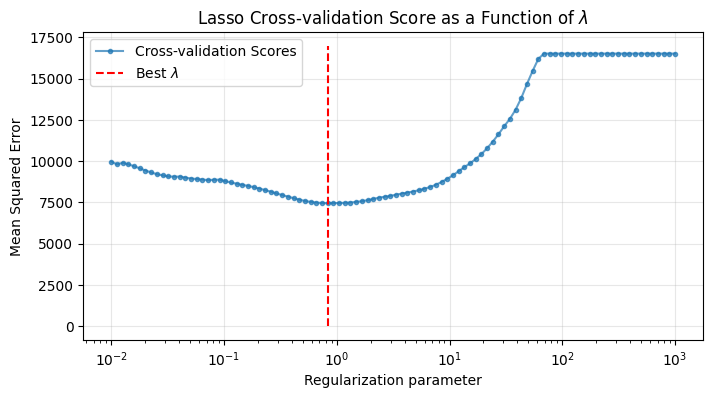

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=1),
    marker="o",
    markersize=3,
    alpha=0.7,
    label="Cross-validation Scores",
)
# Plot the final chosen regularization parameter
ax.vlines(
    lasso_cv.alpha_,
    0,
    ax.get_ylim()[1],
    linestyle="--",
    color="red",
    label=r"Best $\lambda$",
)

# Aesthetics
ax.set_xscale("log")
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("Mean Squared Error")
ax.set_title(r"Lasso Cross-validation Score as a Function of $\lambda$")
ax.grid(alpha=0.3)
ax.legend()

print(f"Best regularization parameter: {lasso_cv.alpha_:.2f}")

In [ ]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, dataset_name: str) -> None:
    """"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")


y_train_pred = lasso_cv.predict(X_train_scaled)
y_test_pred = lasso_cv.predict(X_test_scaled)

evaluate_model(y_train, y_train_pred, "train")
evaluate_model(y_test, y_test_pred, "test")


train Metrics:
R² Score: 0.6101
RMSE: 80.16
MAE: 52.51

test Metrics:
R² Score: 0.5020
RMSE: 96.20
MAE: 57.41


\coeffs:
                                                 feat      coeff
219                          wins_host_listings_count  80.071991
153                                log_minimum_nights -32.872848
223                                 wins_accommodates  24.441683
207                            log_tourism_restaurant  21.581422
1                           host_total_listings_count -19.389650
177  log_calculated_host_listings_count_private_rooms -16.482194
103  sqrt_calculated_host_listings_count_entire_homes -16.220963
156                        log_maximum_minimum_nights  15.363254
38                                      amenity_count  15.094546
224                                     wins_bedrooms  14.725082
215                  log_tourism_points_within_radius  13.746828
195                                 log_tourism_hotel  13.384171
39                                   tourism_barorpub -12.693071
284                    wins_tourism_touristattraction  11.562656
258             

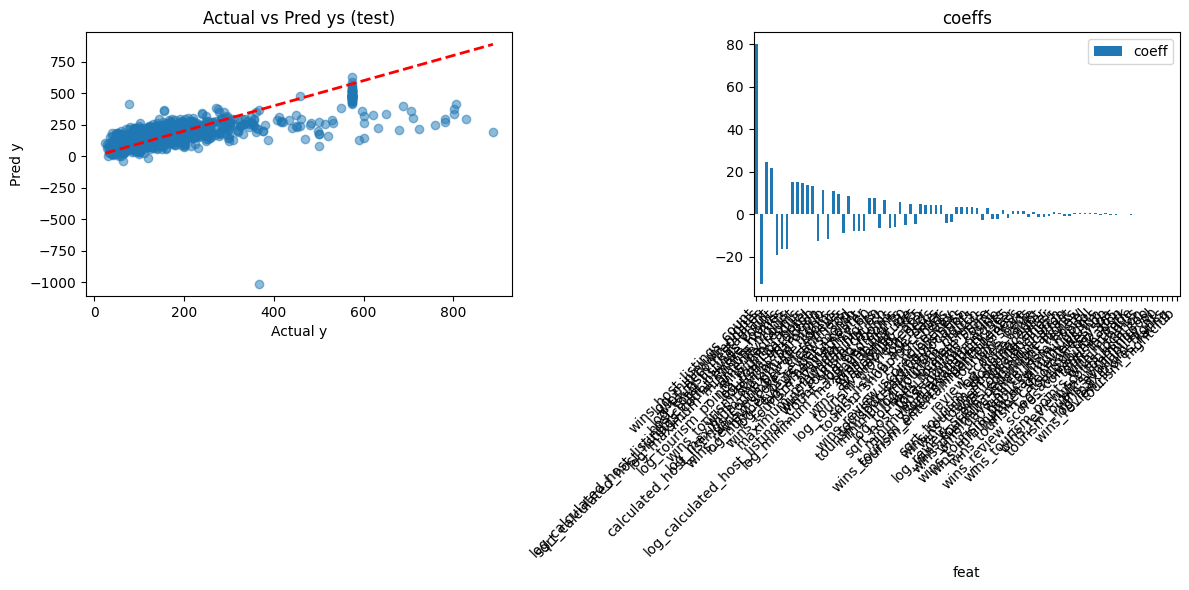

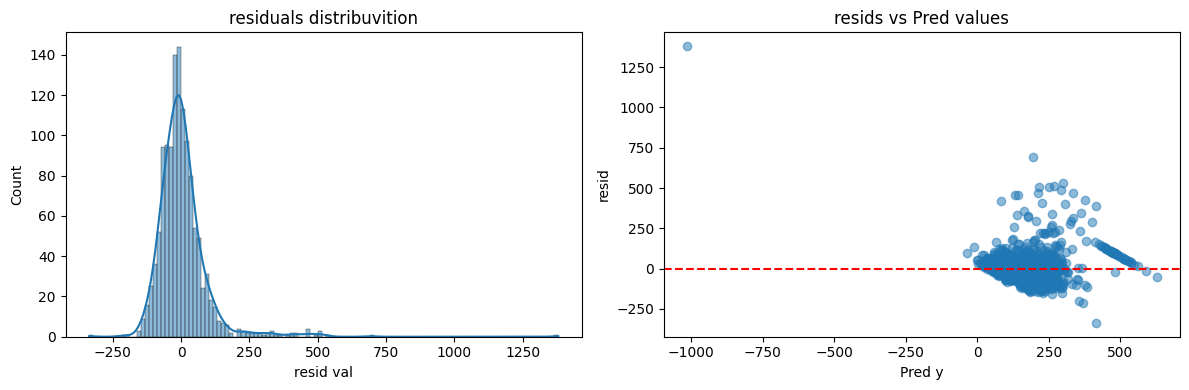

In [ ]:
feature_importance = pd.DataFrame({"feat": X.columns, "coeff": lasso_cv.coef_})

feature_importance["Abs_coeff"] = abs(feature_importance["coeff"])
feature_importance_sorted = feature_importance.sort_values("Abs_coeff", ascending=False)
non_zero_features = feature_importance_sorted[feature_importance_sorted["coeff"] != 0]

print(r"\coeffs:")
print(non_zero_features[["feat", "coeff"]].to_string())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual y")
plt.ylabel("Pred y")
plt.title("Actual vs Pred ys (test)")

# Plot 2: feat coeffs
plt.subplot(1, 2, 2)
non_zero_features.plot(kind="bar", x="feat", y="coeff", ax=plt.gca())
plt.xticks(rotation=45, ha="right")
plt.title("coeffs")
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("residuals distribuvition")
plt.xlabel("resid val")

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Pred y")
plt.ylabel("resid")
plt.title("resids vs Pred values")
plt.tight_layout()
plt.show()

In [ ]:
coefficient_df = pd.DataFrame(
    {
        "feature": X.columns,
        "coeff": lasso_cv.coef_,
        "coeff_abs": abs(lasso_cv.coef_),
    }
)

coefficient_df = coefficient_df.sort_values("coeff_abs", ascending=False)
coefficient_df

,feature,coeff,coeff_abs
219,wins_host_listings_count,80.071991,80.071991
153,log_minimum_nights,-32.872848,32.872848
223,wins_accommodates,24.441683,24.441683
207,log_tourism_restaurant,21.581422,21.581422
1,host_total_listings_count,-19.389650,19.389650
...,...,...,...
116,sqrt_tourism_casino,-0.000000,0.000000
118,sqrt_tourism_civicstructure,-0.000000,0.000000
119,sqrt_tourism_dayspa,-0.000000,0.000000
120,sqrt_tourism_entertainmentbusiness,0.000000,0.000000
